# Content and Objectives

- Show PSD of ASK for random data
- Spectra are determined using FFT and averaging along several realizations

<b> Note: </b> You may extend these lines to include other modulation schemes

# Import

In [1]:
# importing
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

In [2]:
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)

matplotlib.rc('figure', figsize=(18, 10) )

# Function for determining the impulse response of an RC filter

In [13]:

########################
# find impulse response of an RRC filter
########################
def get_rrc_ir(K, n_sps, t_symbol, beta):
    
    ''' 
    Determines coefficients of an RRC filter 
    
    Formula out of: J. Huber, Trelliscodierung, Springer, 1992, S. 15
    
    NOTE: roll-off factor must not equal zero
    
    NOTE: Length of the IR has to be an odd number
    
    IN: length of IR, sps factor, symbol time, roll-off factor
    OUT: filter coefficients
    '''
    
    if beta == 0:
        beta = 1e-32
    
    K = int(K) 

    if ( K%2 == 0):
        raise ValueError('Length of the impulse response should be an odd number')
    
        
    # initialize np.array    
    rrc = np.zeros( K )
    
    # find sample time and initialize index vector
    t_sample = t_symbol / n_sps
    time_ind = range( -(K-1)//2, (K-1)//2+1)

    # assign values of rrc
    for t_i in time_ind:
        t = (t_i)* t_sample    

        if t_i == 0:
            rrc[ int( t_i+(K-1)//2 ) ] = (1-beta+4*beta/np.pi)

        elif np.abs(t) == t_symbol / ( 4 * beta ):             
            rrc[ int( t_i+(K-1)//2 ) ] = beta*np.sin( np.pi/(4*beta)*(1+beta) ) \
                - 2*beta/np.pi*np.cos(np.pi/(4*beta)*(1+beta)) 

        else:
            rrc[ int( t_i+(K-1)//2 ) ] = ( 4 * beta * t / t_symbol * np.cos( np.pi*(1+beta)*t/t_symbol ) \
                + np.sin( np.pi * (1-beta) * t / t_symbol ) ) / ( np.pi * t / t_symbol * (1-(4*beta*t/t_symbol)**2) )

    rrc = rrc  / np.sqrt(t_symbol)
               
    return rrc  

# Parameters

In [14]:
########################
# parameters
########################

# number of realizations along which to average the psd estimate
n_real = 100

# modulation scheme and constellation points
M = 16
constellation = 2. * np.arange( M ) - M + 1
#constellation = np.exp( 1j * 2 * np.pi * np.arange(M) / M )

constellation /= np.sqrt( np.linalg.norm( constellation )**2 / M )

# number of symbols    
n_symb = int( 1e4 )

t_symb = 1.0 

# parameters of the filter
beta = 0.33

n_sps = 4        # samples per symbol
syms_per_filt = 4  # symbols per filter (plus minus in both directions)

K_filt = 2*syms_per_filt * n_sps + 1         # length of the fir filter

# Signals and their spectra

In [15]:
# define rrc filter response        

rrc = get_rrc_ir( K_filt, n_sps, t_symb, beta)
rrc = rrc/ np.linalg.norm(rrc)

# get frequency regime and initialize PSD
omega = np.linspace( -np.pi, np.pi, 512)
psd = np.zeros( (n_real, len(omega) ) )
psd_str = np.zeros( (n_real, len(omega) ) )        


# loop for realizations
for k in np.arange(n_real):

    # generate random binary vector and modulate the specified modulation scheme
    d = np.random.randint( M, size = n_symb)
    s = constellation[ d ]

    # prepare sequence to be filtered
    s_up = np.zeros(n_symb * n_sps, dtype=complex)        
    s_up[ : : n_sps ] = s
    s_up = np.append( s_up, np.zeros( K_filt - 1 ) )        

    # apply rrc        
    #s_filt_rrc = signal.lfilter(rrc, [1], s_up)
    s_filt_rrc = np.convolve( rrc, s_up )
    x = s_filt_rrc

    # get spectrum using Bartlett method
    psd[k, :] = np.abs( 1 / n_sps * np.fft.fftshift( np.fft.fft( x, 512 ) ) )**2

                            

# average along realizations
psd_average = np.average(psd, axis=0)
psd_str_average = np.average(psd_str, axis=0)    

# Plotting

__main__:3: RuntimeWarning: divide by zero encountered in log10


Text(0, 0.5, '$\\Phi(\\Omega)$')

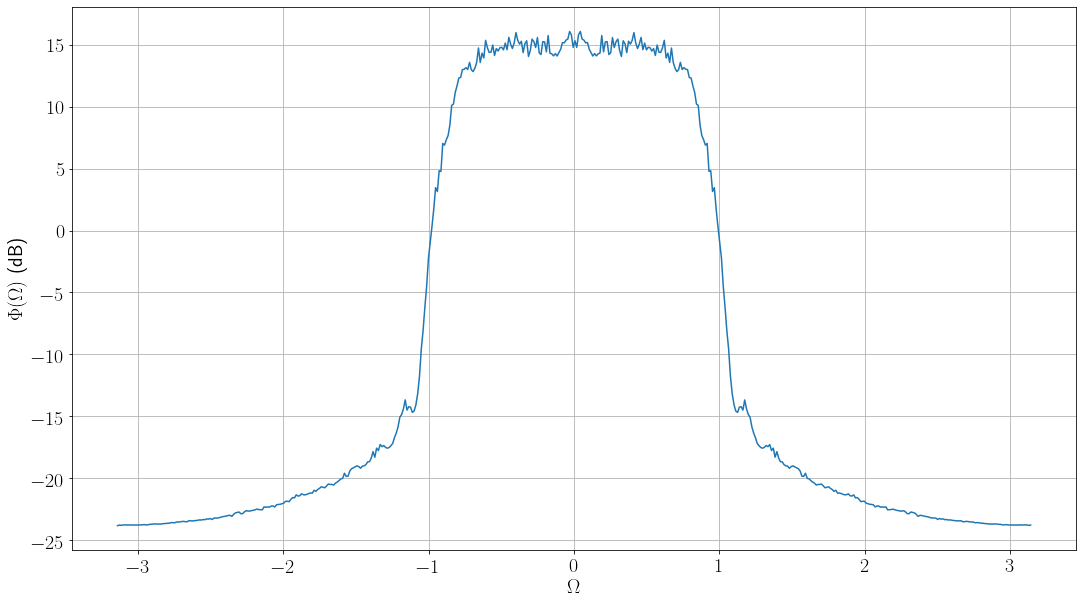

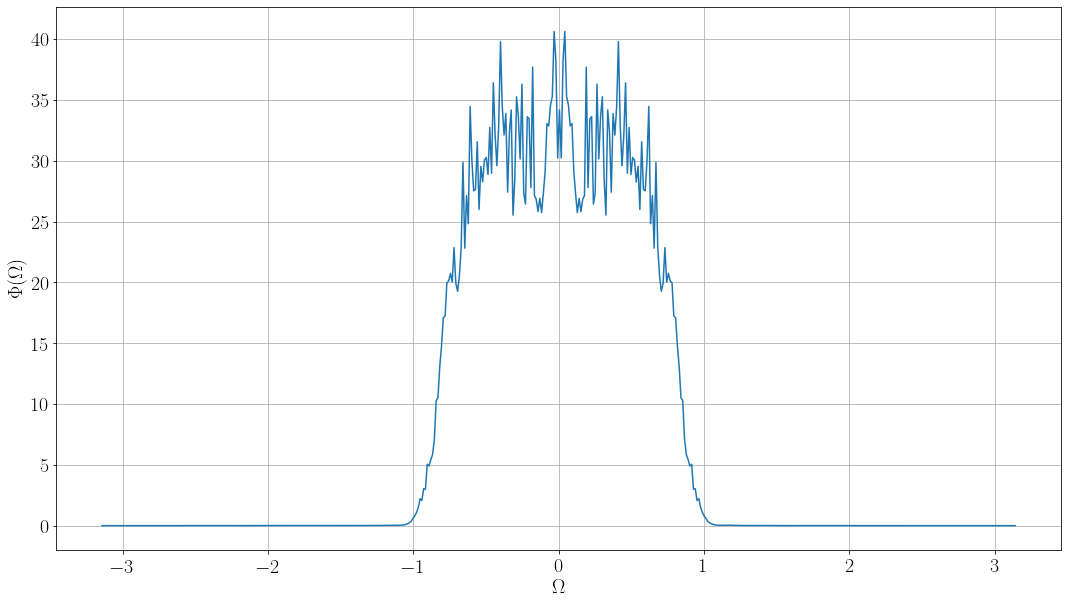

In [16]:
plt.figure()
plt.plot(omega, 10*np.log10(psd_average) )
plt.plot(omega, 10*np.log10(psd_str_average) )    

plt.grid(True); 
plt.xlabel('$\Omega$');  
plt.ylabel('$\Phi(\Omega)$ (dB)')  


plt.figure()

plt.plot(omega, psd_average ) 

plt.grid(True); 
plt.xlabel('$\Omega$');  
plt.ylabel('$\Phi(\Omega)$')    
